In [1]:
%matplotlib notebook
import keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import regularizers,optimizers
from keras.regularizers import l2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import gzip
from keras.layers.core import Lambda
from scipy.integrate import trapz
import seaborn as sns

from keras.layers.core import Lambda
from keras import backend as K    


def mini_batches(InputSample,BatchSize):
    Index = np.array(range(InputSample.shape[0]),dtype=int)
    NumBatches = np.int(InputSample.shape[0]/BatchSize)
    Removed = np.array([],dtype=int)

    BatchInd =[]
    for BatchLoop in range(NumBatches):
        RemainIndex = np.delete(Index,Removed)
        SampleInd = np.random.choice(RemainIndex,size=BatchSize,replace=False)
        Removed = np.append(Removed,SampleInd,axis=0)

        BatchInd.append(SampleInd)
    RemainIndex = np.delete(Index,Removed)
    BatchInd.append(RemainIndex)

    return BatchInd,NumBatches
    
def Get_Feats_and_Targets(filename):
    import numpy as np
    
    def line_to_Feats(line):
        line = line.split(' ')
        Feats = np.asarray(line[0:1024])
        Target = np.zeros([3])
        Target[int(line[1024])] = 1
        return Feats,Target

    f = open(filename, 'r')
    lines = f.readlines()
    Features = []
    Targets = []
    for i in range(len(lines)-1):
        line = lines[i+1]
        Feats,Tgts = line_to_Feats(line)
        Features.append(Feats)
        Targets.append(Tgts)
        
    return np.asarray(Features,dtype = 'float64'), np.asarray(Targets,dtype = 'int')

Using TensorFlow backend.


In [2]:
FullInputs = scipy.io.loadmat('MNIST_TrainInputs.mat')
FullInputs = FullInputs['images']

FullTargets = scipy.io.loadmat('MNIST_TrainTargets.mat')
FullTargets = FullTargets['targets']


In [3]:
Validation_Cutoff = 0.5

Validation_Cutoff = np.int(Validation_Cutoff*FullInputs.shape[0])

ValInputs = FullInputs[Validation_Cutoff:,:]
ValTargets = FullTargets[Validation_Cutoff:,:]

TrainInputs = FullInputs[0:Validation_Cutoff,:]
TrainTargets = FullTargets[0:Validation_Cutoff,:]

In [4]:
data_dim = TrainInputs.shape[-1]
NumSamples = TrainInputs.shape[0]
Num_Targets = TrainTargets.shape[-1]

index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

reg_coeff = 0.001

def Gen_Model(reg_coeff):
    model = Sequential()
    model.add(Dense(100,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(100,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(100,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
    optim = optimizers.sgd(lr=0.001)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
    return model
    
ISHard_model = Gen_Model(reg_coeff)

ISEasy_model = Gen_Model(reg_coeff)

Uni_model = Gen_Model(reg_coeff)

ISHard_model.set_weights(Uni_model.get_weights())
ISEasy_model.set_weights(Uni_model.get_weights())

In [5]:
def average_dist_to_threshold(model,samples,Num_Targets):
    Output = model.predict(samples)
    Output -= 1/float(Num_Targets)
    Dist_to_Threshold = np.mean(np.abs(Output),1)
    return Dist_to_Threshold

def acquisition_function_dist_to_threshold(model,samples,Num_Targets,temperature=1,Rescale=0):
    Output = model.predict(samples)
    Output -= 1/float(Num_Targets)
    Dist_to_Threshold = np.sum(np.abs(Output),1)
    Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
    Exp_Dist_to_Threshold *= 1
#     Exp_Dist_to_Threshold = Dist_to_Threshold
    Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
    if Rescale == 1:
        Median_Prob = np.median(Sampling_Prob)
        Min_Prob = np.min(Sampling_Prob)
        Sampling_Prob[Sampling_Prob > Median_Prob] += Min_Prob/2
        Sampling_Prob[Sampling_Prob < Median_Prob] -= Min_Prob/2
    return Sampling_Prob

def Exp_ModelChange(Model,Inputs,Num_Targets):
    ExpChange = np.zeros(Inputs.shape[0])
    for TargetLoop in range(Num_Targets):
        thisTarget = np.zeros([Inputs.shape[0],Num_Targets])
        thisTarget[:,TargetLoop] = 1
        Model_Output = Model.predict(Inputs)
        ClassProb = Model_Output[:,TargetLoop]
        Loss = np.mean(Model_Output - Model_Output*thisTarget + np.log(1+np.exp(-Model_Output)),1)
        ExpChange += Loss*ClassProb
    return ExpChange

def acquisition_function_exp_model_change(model,samples,Num_Targets,Temperature=1):
    ExpChange = np.exp(Exp_ModelChange(model,samples,Num_Targets)/Temperature)
#     Sampling_Prob = ExpChange/np.sum(ExpChange)
    Sampling_Prob = ExpChange/np.sum(ExpChange).astype(float)
    return Sampling_Prob

def Get_L2_Loss(Model,Coeff=0.01):
    Reg_Loss = 0
    Weights = Model.get_weights()
    NumWeights = len(Weights)
    for i in range(NumWeights):
        LayerWeights = Weights[i]
        LayerWeights_Sq = LayerWeights**2
        Reg_Loss += LayerWeights_Sq.sum()
    Reg_Loss*=Coeff
    return Reg_Loss


def ablate_network(model,ablation_perc):
    weights = model.get_weights()
    save_weights = weights.copy()
    NumLayers = len(weights)
    total_numweights  = 0 
    for i in range(NumLayers):
        layer = weights[i]
        total_numweights += len(layer.flatten())
    num_ablations = np.int(ablation_perc*total_numweights)
    weights = ablate_weights(weights,num_ablations)
    model.set_weights(weights)
        
    return(model,save_weights)


def ablation_curve(model,num_tests,max_perc,inputs,targets):
    Perc_Space = np.linspace(0,max_perc,num_tests)
    Performance = np.zeros(num_tests)
    for i in range(num_tests):
        model,save_weights = ablate_network(model,Perc_Space[i])
        Perf = model.test_on_batch(inputs,targets)
        Performance[i] = Perf[1]
        model.set_weights(save_weights)
        
        AUC = trapz(Performance,Perc_Space)
        
    return AUC,Performance
    
    
def ablate_weights(weights,num_ablations):
    NumLayers = len(weights)
    LayerShape = []
    LayerShape = []
    LayerNodes = [0]
    FlattenedNodes = np.empty([0])
    for i in range(NumLayers):
        LayerShape.append(weights[i].shape)
        LayerNodes.append(len(weights[i].flatten()))
        FlattenedNodes = np.append(FlattenedNodes,weights[i].flatten())
        Index = np.linspace(0,len(FlattenedNodes)-1,num=len(FlattenedNodes),dtype = int)
    RandChoice = np.random.choice(Index,size = num_ablations,replace=False)
    FlattenedNodes[RandChoice] = 0
    FirstInd = 0
    for i in range(NumLayers):
        FirstInd += LayerNodes[i]
        SecondInd = FirstInd + LayerNodes[i+1]
        Sample = FlattenedNodes[FirstInd:SecondInd]
        Sample = Sample.reshape(LayerShape[i])
        weights[i] = Sample
        
    return weights


def acquisition_function_ablation(model,Inputs,Targets,Cluster_Size,Rescale=0):
    BatchInd,NumBatches = mini_batches(Inputs,Cluster_Size)
    AUC_Record = np.zeros([Inputs.shape[0]])
    count= 0
    for Batch in BatchInd:
        if Batch.shape[0] != 0:
            BatchInputs = Inputs[Batch,:]
            BatchTargets = Targets[Batch,:]
            SaveWeights = model.get_weights()
            model.fit(BatchInputs,BatchTargets,batch_size=64,verbose=0)
            AUC,_ = ablation_curve(model,10,1,Inputs,Targets)
            AUC_Record[Batch] = AUC.copy()
            model.set_weights(SaveWeights)
            count +=1
        
    Sampling_Prob = AUC_Record/AUC_Record.sum()
    if Rescale == 1:
        Median_Prob = np.median(Sampling_Prob)
        Min_Prob = np.min(Sampling_Prob)
        Sampling_Prob[Sampling_Prob > Median_Prob] += Min_Prob/2
        Sampling_Prob[Sampling_Prob < Median_Prob] -= Min_Prob/2
    return Sampling_Prob
    
    


In [6]:
count = 0 
Num_Epochs = 256
Num_BurnIn = 1
Batch_Size = 30

Smoothing_Constant = 0

Val_Error = np.zeros([Num_Epochs,3])
Val_Acc = np.zeros([Num_Epochs,3])


<IPython.core.display.Javascript object>


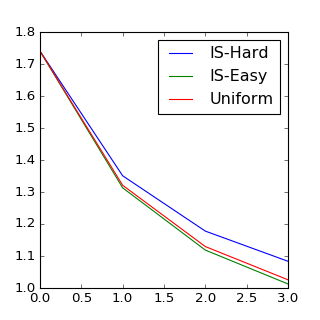

<IPython.core.display.Javascript object>


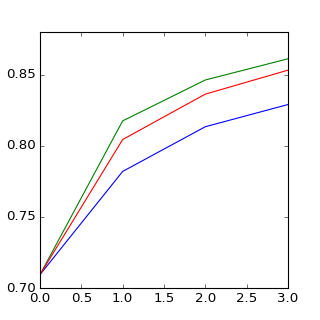

<IPython.core.display.Javascript object>


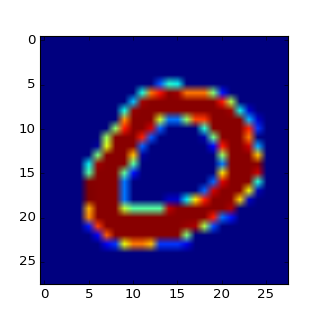

<IPython.core.display.Javascript object>


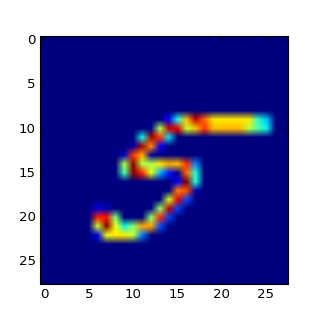

13.31907
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.8859 - categorical_accuracy: 0.8700
Epoch 1/1
1000/1000 [==============================] - 3s 3ms/step - loss: 1.2130 - categorical_accuracy: 0.8023
Epoch 1/1
1000/1000 [==============================] - 3s 3ms/step - loss: 1.0634 - categorical_accuracy: 0.8454
0
13.321623
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.8635 - categorical_accuracy: 0.8933
Epoch 1/1
1000/1000 [==============================] - 3s 3ms/step - loss: 1.1348 - categorical_accuracy: 0.8138
Epoch 1/1
1000/1000 [==============================] - 3s 3ms/step - loss: 0.9809 - categorical_accuracy: 0.8626
1
13.287855
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.9142 - categorical_accuracy: 0.8833


KeyboardInterrupt: 

In [8]:
fig = plt.figure(figsize = [4,4])
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

fig2 = plt.figure(figsize = [4,4])
ax2 = fig2.add_subplot(111)
plt.ion()
fig2.show()
fig2.canvas.draw()

fig3 = plt.figure(figsize = [4,4])
ax3 = fig3.add_subplot(111)
plt.ion()
fig3.show()
fig3.canvas.draw()

fig4 = plt.figure(figsize = [4,4])
ax4 = fig4.add_subplot(111)
plt.ion()
fig4.show()
fig4.canvas.draw()

def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1):
    while True: 
        index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
#         Sampling_Probability = Sampling_Probability/Sampling_Probability.sum()
        Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
        Batch_Inputs = Inputs[Batch,:]
        Batch_Targets = Targets[Batch,:]
        if Weighting_Flag == 1:
            FullWeights = Sampling_Probability**-1
            FullWeights = FullWeights/np.mean(FullWeights)
        elif Weighting_Flag == -1:
            FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
        else:
            FullWeights = np.ones(Inputs.shape[0])
            
        Weights = FullWeights[Batch]
        yield (Batch_Inputs,Batch_Targets,Weights)


for EpochLoop in  range(Num_Epochs):
    if count < Num_BurnIn:
#         ISHard_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
#         Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
#         Val_Error[count,0] = Error[0]
#         Val_Acc[count,0] = Error[1]
        
#         ISEasy_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,verbose=0)
#         Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
#         Val_Error[count,1] = Error[0]
#         Val_Acc[count,1] = Error[1]

        Uni_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,verbose=0)
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]
        
        ISHard_model.set_weights(Uni_model.get_weights())
        ISEasy_model.set_weights(Uni_model.get_weights())
        
        Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]
        
        Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]
        
        
    else:
        Hard_Sampling_Probability = acquisition_function_dist_to_threshold(ISHard_model,TrainInputs,Num_Targets,0.6)
        Easy_SamplingProbability = 1/acquisition_function_dist_to_threshold(ISEasy_model,TrainInputs,Num_Targets,0.6)
        Easy_SamplingProbability/= Easy_SamplingProbability.sum().astype(float)
        print(Hard_Sampling_Probability.max()/Hard_Sampling_Probability.min())
        
        MaxProbInd = Hard_Sampling_Probability.argmax()
        MinProbInd = Hard_Sampling_Probability.argmin()
        
        ax3.clear()
        ax3.imshow(np.transpose(np.reshape(TrainInputs[MaxProbInd,:],[28,28])))
        fig3.canvas.draw()
                   
                   
        ax4.clear()
        ax4.imshow(np.transpose(np.reshape(TrainInputs[MinProbInd,:],[28,28])))
        fig4.canvas.draw()
    
        
        
        
        ISHard_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Hard_Sampling_Probability,0),
                                   steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        ISEasy_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Easy_SamplingProbability,0),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        
        Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/np.float(NumSamples)*np.ones(NumSamples)),
                                steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]
        
        Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]
        
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]


    print(EpochLoop)
    
    ax.clear()
    ax.plot(Val_Error[0:count,0],label='IS-Hard')
    ax.plot(Val_Error[0:count,1],label='IS-Easy')
    ax.plot(Val_Error[0:count,2],label='Uniform')
    ax.legend(loc='best')
    fig.canvas.draw()
    
    ax2.clear()
    ax2.plot(Val_Acc[0:count,0],label='IS-Hard')
    ax2.plot(Val_Acc[0:count,1],label='IS-Easy')
    ax2.plot(Val_Acc[0:count,2],label='Uniform')
    fig2.canvas.draw()
    
    
    
    count += 1

In [9]:
TestInputs = scipy.io.loadmat('MNIST_TestInputs.mat')
TestInputs = TestInputs['test_images']

TestTargets = scipy.io.loadmat('MNIST_TestTargets.mat')
TestTargets = TestTargets['test_targets']

In [9]:
TestError = np.zeros([3,2])
TestError[0,:] = ISHard_model.test_on_batch(TestInputs,TestTargets)
TestError[1,:] = ISEasy_model.test_on_batch(TestInputs,TestTargets)
TestError[2,:] = Uni_model.test_on_batch(TestInputs,TestTargets)

In [10]:
TestError

array([[0.39819056, 0.95050001],
       [0.38460419, 0.96850002],
       [0.38212889, 0.96039999]])

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [12]:
test = TrainInputs[0,:]

In [13]:
test = test.reshape([28,28])

In [15]:
plt.imshow(test)

In [16]:
plt.show()

In [8]:
np.int(NumSamples/Batch_Size)

1000

In [9]:
NumSamples

30000